In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from scipy.io import loadmat
%matplotlib inline

np.random.seed(2)
import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
from keras.layers import Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input

from keras import utils as np_utils
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

from keras import regularizers
from keras import metrics
from scipy import misc

from keras.callbacks import TensorBoard

/home/sdc/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
data_path = "./data.mat"
data_raw = loadmat(data_path)

train_img = data_raw["train_img"]
test_img = data_raw["test_img"]
train_lbl = data_raw["train_lbl"]

## add noise

In [3]:
def saltpepper(trn_data): 
    # input is a n*28*28*1 numpy array, reshape each row to a 28*28 matrix
    row = trn_data.shape[0]
    for i in range(row):
        t = trn_data[i]
        t = t.reshape((28, 28))
        val = [1, 0]
        ver_idx = random.randint(4, 15)
        hor_idx = random.randint(4, 15)

        t[ver_idx:(ver_idx+10), hor_idx:(hor_idx+10)] = np.random.choice(val, size=(10, 10))
        
        t = t.reshape((28,28,1))
        trn_data[i] = t 
    return trn_data

noise_factor = 100/255
def gauss(trn_data):
    # input is a n*28*28*1 numpy array, reshape each row to a 28*28 matrix
    row = trn_data.shape[0]
    for i in range(row):
        t = trn_data[i]
        t = t.reshape((28, 28))
        t[4:24, 4:24] = t[4:24, 4:24] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(20,20)) 

        t = t.reshape((28,28,1))
        trn_data[i] = t
    return trn_data

In [4]:
random_seed = 2

x_train_nor = np.reshape(train_img[0:20000], (len(train_img[0:20000]), 28, 28, 1))/255
x_train_sp = np.reshape(train_img[20000:50000], (len(train_img[20000:50000]), 28, 28, 1))/255
x_train_gs = np.reshape(train_img[20000:50000], (len(train_img[20000:50000]), 28, 28, 1))/255

ae_x_lbl = np.concatenate((x_train_nor, x_train_sp, x_train_gs)) # "labels" for auto encoder

ae_x_train_sp = saltpepper(x_train_sp)
ae_x_train_gs = np.clip(gauss(x_train_gs), 0., 1.)

ae_x_trn = np.concatenate((x_train_nor, ae_x_train_sp, ae_x_train_gs)) # "features" for auto encoder

print(ae_x_lbl.shape)
print(ae_x_trn.shape)

(80000, 28, 28, 1)
(80000, 28, 28, 1)


### Train Auto Encoder

In [5]:
#split data
ae_trn_X, ae_val_X, ae_trn_lb, ae_val_lb = train_test_split(ae_x_trn,
                                                             ae_x_lbl, 
                                                             test_size=0.1, 
                                                             random_state=13)

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(ae_trn_X, ae_trn_lb,
                epochs=80,
                batch_size=128,
                shuffle=True,
                validation_data=(ae_val_X, ae_val_lb),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])



Train on 72000 samples, validate on 8000 samples
Epoch 1/80
72000/72000 [==============================] - 6s 85us/step - loss: 0.1490 - val_loss: 0.1174
Epoch 2/80
72000/72000 [==============================] - 6s 77us/step - loss: 0.1141 - val_loss: 0.1084
Epoch 3/80
72000/72000 [==============================] - 6s 78us/step - loss: 0.1079 - val_loss: 0.1047
Epoch 4/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.1043 - val_loss: 0.1048
Epoch 5/80
72000/72000 [==============================] - 5s 71us/step - loss: 0.1022 - val_loss: 0.1008
Epoch 6/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.1006 - val_loss: 0.1011
Epoch 7/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.0992 - val_loss: 0.0989
Epoch 8/80
72000/72000 [==============================] - 5s 74us/step - loss: 0.0981 - val_loss: 0.0974
Epoch 9/80
72000/72000 [==============================] - 5s 74us/step - loss: 0.0973 - val_loss: 0.0982
Epoch 

Epoch 78/80
72000/72000 [==============================] - 5s 75us/step - loss: 0.0871 - val_loss: 0.0881
Epoch 79/80
72000/72000 [==============================] - 5s 74us/step - loss: 0.0871 - val_loss: 0.0873
Epoch 80/80
72000/72000 [==============================] - 5s 74us/step - loss: 0.0870 - val_loss: 0.0879


### Test Auto Encoder on the Test Set

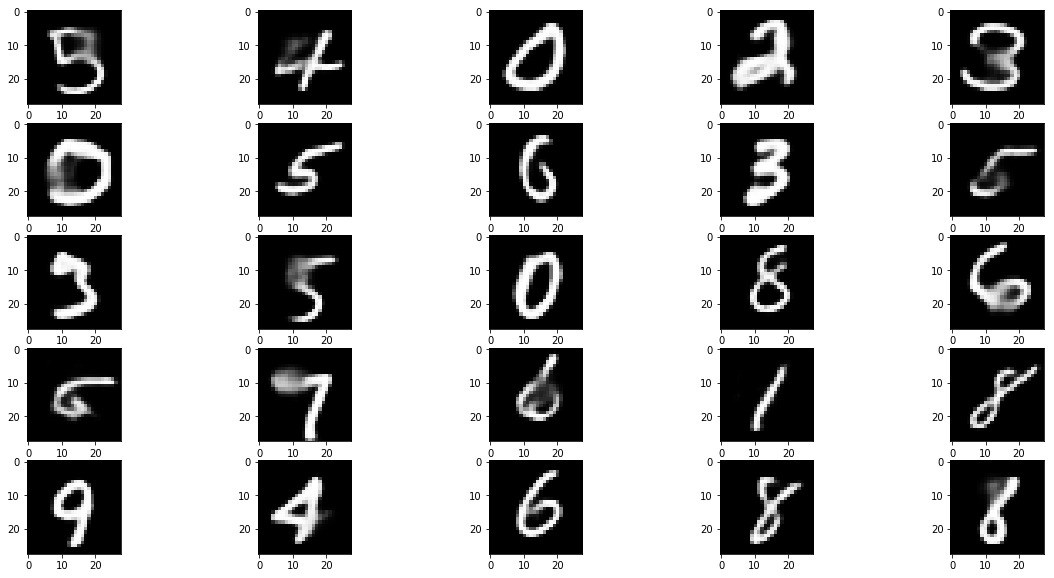

In [6]:
X_tst = np.reshape(test_img, (len(test_img), 28, 28, 1))/255 

clean_tst = autoencoder.predict(X_tst, batch_size=128)

length = clean_tst.shape[0]
result_tst = np.zeros(shape=(length, 784))
for i in range(length):
    result_tst[i,:] = result_tst[i,:] + clean_tst[i].reshape(1, 784)

result_viz = result_tst
plt.figure(figsize=(20,10))
for index, image in enumerate(result_viz[25:50]):
    plt.subplot(5, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

### CNN-Training Labels

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trn_nor = train_lbl[0:20000]
Y_trn_sp = train_lbl[20000:50000]
Y_trn_gs = train_lbl[20000:50000]

Y_trn_nor = np_utils.to_categorical(Y_trn_nor, num_classes = 10)
Y_trn_sp = np_utils.to_categorical(Y_trn_sp, num_classes = 10)
Y_trn_gs = np_utils.to_categorical(Y_trn_gs, num_classes = 10)

Y_trn_all = np.concatenate((Y_trn_nor, Y_trn_sp, Y_trn_gs))
Y_trn_all.shape

(80000, 10)

### CNN-Training Features

In [8]:
X_trn_all = autoencoder.predict(ae_x_trn, batch_size=128)
# X_tst is clean_tst
X_trn_all.shape

(80000, 28, 28, 1)

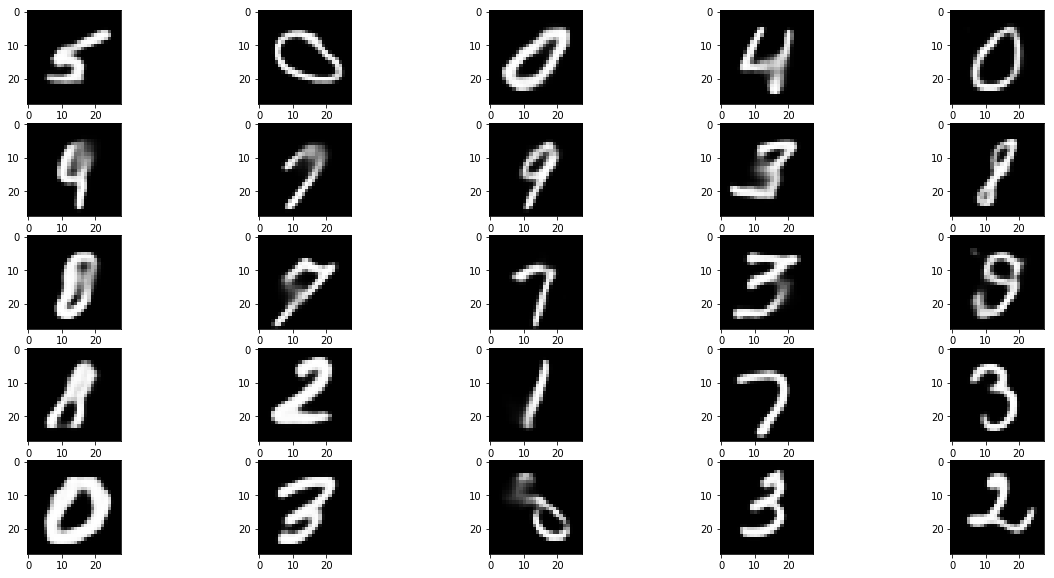

In [9]:
plt.figure(figsize=(20,10))
for index, image in enumerate(X_trn_all[random.sample(range(1, 60000), 25)]):
    plt.subplot(5, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

## split data

In [10]:
X_trn, X_val, Y_trn, Y_val = train_test_split(X_trn_all, Y_trn_all, test_size = 0.1, random_state=random_seed)

# CNN

In [11]:
epochs = 30 
batch_size = 64
num_classes = 10


input_shape = (28, 28, 1)
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Valid', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=["accuracy"])
model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=0, 
                                            factor=0.2, 
                                            min_lr=0.00001)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_trn)

In [13]:
# Fit the model

history = model.fit_generator(datagen.flow(X_trn,Y_trn, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_trn.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)


Epoch 1/30
1125/1125 [==============================] - 15s 13ms/step - loss: 0.3410 - acc: 0.8908 - val_loss: 0.1972 - val_acc: 0.9396
Epoch 2/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.2052 - acc: 0.9360 - val_loss: 0.1215 - val_acc: 0.9619
Epoch 3/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.1818 - acc: 0.9440 - val_loss: 0.1183 - val_acc: 0.9624
Epoch 4/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.1708 - acc: 0.9462 - val_loss: 0.1143 - val_acc: 0.9639
Epoch 5/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.1596 - acc: 0.9504 - val_loss: 0.1095 - val_acc: 0.9653
Epoch 6/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.1562 - acc: 0.9515 - val_loss: 0.0898 - val_acc: 0.9724
Epoch 7/30
1125/1125 [==============================] - 13s 12ms/step - loss: 0.1464 - acc: 0.9548 - val_loss: 0.0899 - val_acc: 0.9738
Epoch 8/30
1125/1125 [==========================

In [14]:
results = model.predict(clean_tst)
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Prediction")
submission = pd.concat([pd.Series(range(1,20001),name = "ID"),results],axis = 1)

submission.to_csv("CNN.csv",index=False)